In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

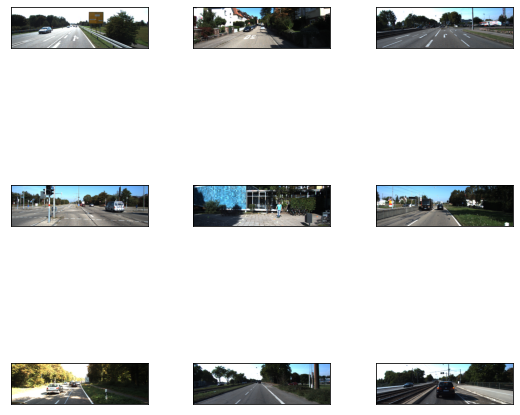

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel-dj26/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
    

In [5]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

NameError: name 'TakeDataset' is not defined

In [ ]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [7]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [13:22<00:00,  7.91it/s]


In [8]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:35<00:00,  7.45it/s]


In [9]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

In [5]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 1 --epochs 50 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ~/aiffel/object_detection/data/classes.txt

ndeterministic deadlocks. For high performance data pipelines tf.data is recommended.
2021-04-27 07:44:15.057786: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-04-27 07:44:16.158057: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-04-27 07:44:16.186248: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-27 07:44:16.421199: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
195/195 [==============================] - 79s 186ms/step - loss: 3.6683 - regression_loss: 2.6602 - classification_loss: 1.0080

Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
Epoch 2/50
195/195 [=======================

In [6]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_10.h5 ./snapshots/resnet50_csv_50_infer.h5

2021-04-27 08:15:46.192796: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 08:15:47.631305: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-27 08:15:47.634234: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-27 08:15:47.666186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 08:15:47.666643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 08:15:47.666670: I tensorflow/stream_executor/platform/default/d

In [8]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join('.', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1 Physical GPUs, 1 Logical GPUs
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experime

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[593.25653 177.33316 623.2011  204.38531]


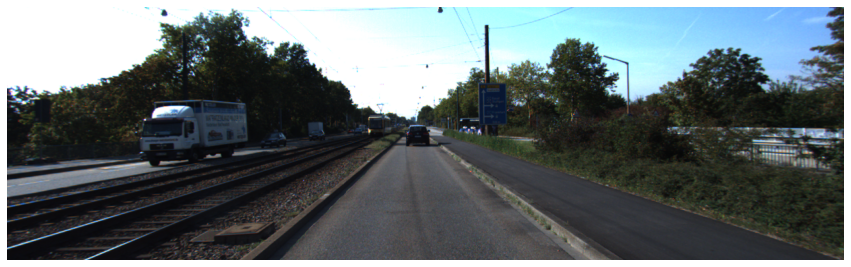

In [12]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[763.8725  148.30295 835.6422  301.47617]
[785.97003 143.06624 872.5017  307.903  ]


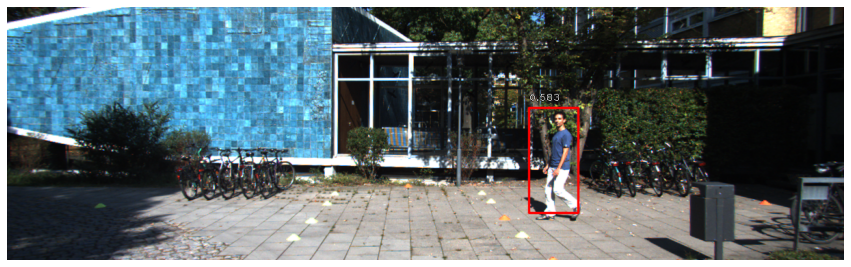

In [24]:
img_path = os.getenv('HOME')+ '/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

In [15]:
def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if label == 1:
            return "Stop"
        elif label == 0:
            width = box[2] - box[0]
            height = box[3] - box[1]
            if width > 300 or height > 300:
                return "Stop"  
        if score < 0.5:
            return "Go"

print(self_drive_assist(img_path)) 

Stop


In [16]:
import os

def test_system(func):
    work_dir =  os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

90점입니다.


# 고찰
retinanet에 대해 잘 모르고 진행 할 수 있을 정도로 간단한 과제였다.  
아쉬운 점으로 다른 모델들과 비교하는 과정이 노드에 없어 retina model의 장점을 크게 못 느꼈다.

